# Module 3 - Algorithm auditing: Accuracy, Fairness and Interpretability 


### Assignment overview

In this assignment, you will be asked to evaluate a set of trained classifiers for accuracy, fairness and transparency. The classifiers have been trained on the [NIJ Recidivism Challenge Dataset](https://nij.ojp.gov/funding/recidivism-forecasting-challenge) to predict whether or not an individual will be arrested for a new crime within 3 years after being released on parole. 

The assignment is modeled after “Accuracy, Fairness, and Interpretability of Machine Learning Criminal Recidivism Models, by Eric Ingram, Furkan Gursoy, Ioannis A. Kakadiaris (https://arxiv.org/abs/2209.14237). 

For this assignment, it is possible to work in **groups of up to 2 students**. Read the instructions carefully, as they may assign tasks to specific students.

### Group members
Leave blanks if group has less than 2 members:
- Student 1: Yanxin Liang 50798412
- Student 2: Yelia Ye 89657605


### Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:
1. Describe different fairness metrics, such as statistical parity, equal opportunity and equal accuracy 
2. Discuss fairness and fairness metrics from the perspective of multiple stakeholders 
3. Define objective functions based on fairness metrics  
4. Evaluate a model’s transparency using strategies such as global surrogate models, permutation feature importance, and Shapley Additive Explanations (SHAP) 
5. Evaluate common machine learning models based on their accuracy, fairness and interpretability 
6. Describe how metrics such as accuracy and fairness need to be balanced for a trained model to have acceptable accuracy and low bias 

## Import Libraries:

In [1]:
# Here are some libraries you may need for this exercise, for your convenience

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    #plot_confusion_matrix,
    f1_score,
    make_scorer,
    ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import export_text


import joblib
from sklearn import tree
from sklearn.inspection import permutation_importance
import eli5

import warnings
warnings.filterwarnings("ignore")

# Part 1: Getting started:

Before starting this assignment, we ask you to read the paper it has been modeled after, to get an idea of the problem we are working on: https://arxiv.org/abs/2209.14237

You can also review the original dataset source [here](https://nij.ojp.gov/funding/recidivism-forecasting-challenge). The website includes a lot of information on the dataset and a detailed description of each of its columns (look for Appendix 2: Codebook).

Now that you have familiarized with the problem, you know that the goal is predicting the binary variable `Recidivism_Within_3years`, which indicates whether or not the person has committed a new felony or misdemeanour within 3 years from the beginning of parole supervision. 

The National Institute of Justice’s (NIJ) obviously would want to deploy a highly accurate predictive model, to make sure that only deserving people get released on parole. Unfortunately, the existence of bias in the training set (typically historical or representation bias) makes it very likely to end up with an unfair classifier, that is, a classifier that produces different results for different protected classes of population.

Your job is to evaluate 5 classifiers, pre-trained and provided to you. This is called **algorithm auditing:** you are not the designer of the model, but you are in charge of evaluating its performance. Algorithm auditing can focus on various metrics and populations of interest, but in this case we will focus on evaluating **accuracy, fairness and transparency** of each algorithm.

To begin, load the datasets and classsifiers by running the cells below:

In [2]:
# Note: these training and test sets do not correspond to the ones on the NIJ's website,
# they are our own partition

train_df = pd.read_csv("training_set.csv")
test_df = pd.read_csv("testing_set.csv")

In [3]:
# Creating training and test sets and separating features and target
X_train, y_train = (
    train_df.drop(columns=["Recidivism_Within_3years"]),
    train_df["Recidivism_Within_3years"],
)
X_test, y_test = (
    test_df.drop(columns=["Recidivism_Within_3years"]),
    test_df["Recidivism_Within_3years"],
)

In [4]:
# Loading classifiers
logreg_model  = joblib.load("models_for_A3/NIJ_logreg.joblib")
rf_model      = joblib.load("models_for_A3/NIJ_rf.joblib")
tree_model    = joblib.load("models_for_A3/NIJ_tree.joblib")
xgboost_model = joblib.load("models_for_A3/NIJ_xgboost.joblib")

# Part 2: Classifiers' Accuracy (and other performance metrics):

First, we will evaluate each classifier's accuracy, together with other performance metrics that help us understanding how reliable the classifier's answers are. In addition to accuracy, we will use, **precision, recall, F1 score, and Area Under the Curve (AUC).**

### Question 1

can you provide definition and formula for accuracy, precision, recall and F1 score?

It may help you use this table for reference:

<img src="ConfMatrix.png" alt="drawing" width="500"/>

Here, we are giving you the definition of AUC, as a reminder and example (note that the other metrics will need the formula):

**AUC:** AUC stands for Area Under the ROC curve. The ROC (receiver operating characteristic) curve is a plot of the recall and false positive rate of a classifier for different classification thresholds (see [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) for more details). AUC values go between 0 and 1. Higher values are more desirable as they indicate that the classifier is good at avoiding both false positives and false negatives. A value of 0.5 for a binary classification indicates that the classifier is no better at predicting the outcome than random guessing.

**Accuracy:** accuracy is the proportion of the correct predictions:
$$ accuracy =  \frac{correct\ predictions}{total\ examples} = \frac{TP+TN}{TP+TN+FP+FN} $$

**Precision:** precision is the proportion of true positive predictions out of all predicted positive cases.:
$$ precision =  \frac{correct\ positive\ predictions\ }{all\ predicted\ positive\ cases} = \frac{TP}{TP+FP} $$

**Recall:** recall is the proportion of the correct positive prediction in all actual cases. It is also called sensitivity, coverage, true positive rate (TPR):
$$ recall =  \frac{correct\ positive\ predictions}{all\ actual\ cases} = \frac{TP}{TP+FN} $$

**F1 score:** F1-score is a harmonic mean of precision and recall. F1-score combines precision and recall to give one score:
$$ f1 =  2 \times \frac{precision \times recall}{precision + recall} $$


### Question 2

For every classifier given, calculate and report accuracy, precision, recall, F1 score, and AUC on both training and test set. **For ease of visualization, summarize these results in one or two tables below this question.**

**Hints:** 
- Scikit-learn provides a lot of useful built-in functions to compute performance metrics. You can find them all in the package [`sklearn.metrics`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics), under Classification Metrics.
- Some classifiers may take longer than others to make their predictions, so you may have to wait a few minutes for a cell to run. More than that, however, likely means something is wrong and needs to be fixed before continuing.

### LogReg Model:

In [5]:
logreg_model.fit(X_train, y_train)

print(classification_report(y_test, logreg_model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.65      0.69      0.67      3373
        True       0.75      0.71      0.73      4378

    accuracy                           0.70      7751
   macro avg       0.70      0.70      0.70      7751
weighted avg       0.71      0.70      0.70      7751



### Random Forest Model:

In [6]:
rf_model .fit(X_train, y_train)

print(classification_report(y_test, rf_model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.72      0.59      0.65      3373
        True       0.72      0.82      0.77      4378

    accuracy                           0.72      7751
   macro avg       0.72      0.70      0.71      7751
weighted avg       0.72      0.72      0.71      7751



### Decision Tree Model:

In [7]:
tree_model.fit(X_train, y_train)

print(classification_report(y_test, tree_model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.67      0.60      0.63      3373
        True       0.71      0.78      0.74      4378

    accuracy                           0.70      7751
   macro avg       0.69      0.69      0.69      7751
weighted avg       0.70      0.70      0.70      7751



### XGBoost Model:

In [8]:
xgboost_model.predict(X_train)

print(classification_report(y_test, xgboost_model.predict(X_test)))

              precision    recall  f1-score   support

       False       0.73      0.62      0.67      3373
        True       0.74      0.83      0.78      4378

    accuracy                           0.74      7751
   macro avg       0.74      0.72      0.73      7751
weighted avg       0.74      0.74      0.73      7751



### Question 3

For every classifier given, plot the confusion matrices on training and test set. Here is another function you will find helpful for this task: [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

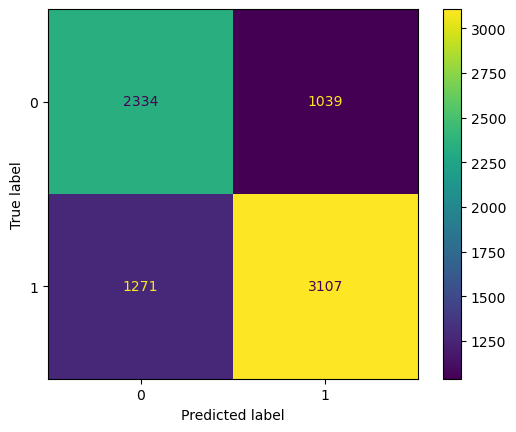

In [9]:
#confusion matrices of logreg_model
cm_logreg=confusion_matrix(y_test, logreg_model.predict(X_test))

ConfusionMatrixDisplay(cm_logreg).plot()

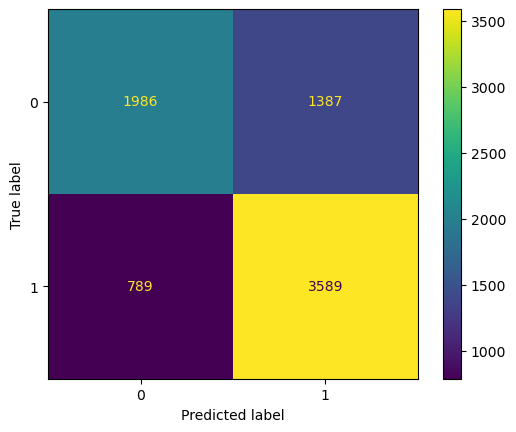

In [10]:
#confusion matrices of rf_model
cm_rf=confusion_matrix(y_test, rf_model.predict(X_test))


ConfusionMatrixDisplay(cm_rf).plot()


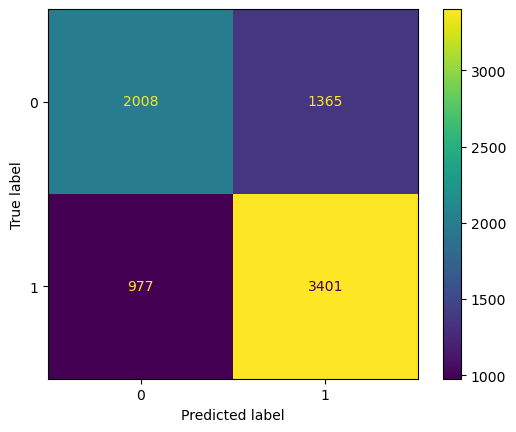

In [11]:
#confusion matrices of tree_model


cm_tree=confusion_matrix(y_test, tree_model.predict(X_test))


ConfusionMatrixDisplay(cm_tree).plot()


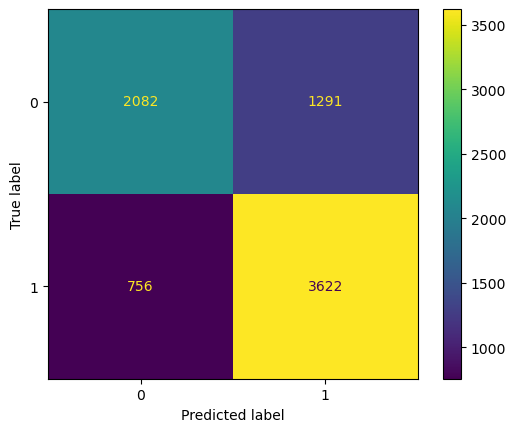

In [12]:
#confusion matrices of xgboost_model

cm_xgboost=confusion_matrix(y_test, xgboost_model.predict(X_test))

ConfusionMatrixDisplay(cm_xgboost).plot()

### Question 4

Based on the results obtained so far, answer the following questions, providing an explanation and trying to base your decision on multiple metrics:
- Which classifiers would you choose for deployment?
- Which classifier is the most "severe" (a.k.a. classifies more people as at risk of committing another crime within 3 years)?
- Which classifier is the most cautious (a.k.a. classifies less people as at risk of committing another crime within 3 years)?

In [13]:

models = ['Logistic Regression', 'Random Forest', 'Decision Tree', 'XGBoost']
predicted_at_risk = [cm_logreg[0][1]+cm_logreg[1][1], cm_rf[0][1]+cm_rf[1][1], cm_tree[0][1]+cm_tree[1][1], cm_xgboost[0][1]+cm_xgboost[1][1]]

df = pd.DataFrame({
    'Model': models,
    'Predicted as At-Risk (TP + FP)': predicted_at_risk
})

df

,Model,Predicted as At-Risk (TP + FP)
0,Logistic Regression,4146
1,Random Forest,4976
2,Decision Tree,4766
3,XGBoost,4913


1. I will choose the XGBoost model for deployment because it achieves the highest accuracy, precision, recall, and F1-score among the four classifiers. This indicates that the XGBoost model outperforms the others in predictive performance and it maintains fairness across the two prediction classes, ensuring balanced outcomes for both positive and negative predictions.
2. Random Forest model is the most severe since it produces the highest number of positive predictions, which is 4976. This indicates that the Random Forest model tends to predict the positive class more frequently, which could lead to higher sensitivity but potentially more false positives.
3. Logistic Regression model is the most cautious since it produces the lowest number of positive prediction (4146).This indicates that this model is more conservative in predicting positive class, which might misses some true positive cases. 

# Part 3 :  Fairness Evaluation:

Now that we have an understanding of how accurate our classifiers are across all samples, we need to measure their *fairness* across different categories. In similar problems, we are typically concerned with the classifiers being fair across different segments of protected populations (e.g. different genders or ethnicities). The original paper evaluates fairness for both gender and race, but for the purpose of this exercise we will only look at fairness across race, that is, for White and Black defendants.

### Question 5

As we have seen in class, there is not just one fairness metric, but several, as they have different ways to identify different treatments across populations. The metrics used in the paper, which you will have to replicate, are:

1. *Predicted Positive Rate Disparity (PPRD)*, whether the numbers of positive predictions are on par across groups.
2. *Predicted Positive Group Rate Disparity (PPGRD)*, whether the rates of positive predictions are on par across groups.
3. *False Discovery Rate Disparity (FDRD)*, whether the ratios of false positives to predicted positives are on par across groups.
4. *False Positive Rate Disparity (FPRD)*, whether the ratios of false positives to actual negatives are on par across groups.
5. *False Omission Rate Disparity (FORD)*, whether the ratios of false negatives to predicted negatives are on par across groups.
6. *False Negative Rate Disparity (FNRD)*, whether the ratios of false negatives to actual positives are on par across groups.

Before jumping into code writing, we must make sure that we have a solid understanding of how these metrics are computed from the True Positive, True Negative, False Positive, and False Negative values *for each group*. We will add the subscript *b* and *w* when appropriate to identify metrics from the group of black or white defendants, respectively. Then, we will write the equations for all fairness metrics. The first one is provided to you as an example:

| Metric    | Formula |
| :-------- | :------- |
| PPRD  |  (TPb + FPb) / (TPw + FPw)  |
| PPGRD | ((TPb + FPb)/ (TPb + FPb + TNb + FNb)) / ((TPw + FPw) / (TPw + FPw + TNw + FNw)) |
| FDRD |  (FPb / (TPb + FPb))/(FPw / (TPw + FPw)) |
| FPRD |   (FPb / (TNb + FPb))/(FPw / (TNw + FPw)) |
| FORD | (FNb / (TNb + FNb))/(FNw / (TNw + FNw))  |
| FNRD |   (FNb / (TPb + FNb))/(FNw / (TPw + FNw)) |



Finally, the paper also computes an **Average Distance from Reference** across all the above metrics. This helps us summarizing the fairness of a classifier in a single number. Compute the Average Distance from Reference for all the classifiers, knowing that the reference is 1 (i.e. a score of 1 indicates perfect fairness). Use tha absolute value to compute the distance from the reference (e.g. a FDRD score of 0.80 and one of 1.20 both have a distance from the reference of 0.20).

Now that you have a better understanding of how to compute these metrics, do so for all the classifiers, both on the training and the test sets.

**Hints:**
- There are several ways to write Python code to easily compute the fairness metrics we want. If you have trouble starting, talk with a TA or with the instructor during our in-class work time or office hours to come up with a plan. 
- Instead of copy-pasting code, it is definitely a good idea to create one or more functions to compute the fairness metrics. Writing functions in Python is very easy! If you are new to it, start [here](https://www.geeksforgeeks.org/python-functions/) (stop before Arbitrary Keyword Arguments), and of course, come to us for more help!

In [14]:
# Add as many cells as needed to compute the required metrics for every classifier. You may
# also add markdown cells if you want to add comments or notes about your results.

def fairness_metrics(model,test_x,test_y):
  dict={}
  pred = model.predict(test_x)

  group_white = test_x["Race"] == "WHITE"
  group_black = test_x["Race"] == "BLACK"


  cm_white = confusion_matrix(test_y[group_white], pred[group_white])
  cm_black = confusion_matrix(test_y[group_black], pred[group_black])

  TNw, FPw, FNw, TPw = cm_white.ravel()
  TNb, FPb, FNb, TPb = cm_black.ravel()
  
  dict["PPRD"] = (TPb + FPb) / (TPw + FPw) 
  dict["PPGRD"] = ((TPb + FPb)/ (TPb + FPb + TNb + FNb)) / ((TPw + FPw) /(TPw + FPw + TNw + FNw))
  dict["FDRD"]= (FPb / (TPb + FPb))/(FPw / (TPw + FPw))
  dict["FPRD"] = (FPb / (TNb + FPb))/(FPw / (TNw + FPw))
  dict["FORD"] = (FNb / (TNb + FNb))/(FNw / (TNw + FNw)) 
  dict["FNRD"] = (FNb / (TPb + FNb))/(FNw / (TPw + FNw))


  AVG_D = sum(abs(value - 1) for value in dict.values()) / 6

  dict["Average Distance from Reference"] = AVG_D


  df =  pd.DataFrame(list(dict.items()), columns=['Metric', 'Value'])
  return df


In [15]:


results_dict = {
    "Logistic Regression": fairness_metrics(logreg_model, X_test, y_test),
    "Random Forest": fairness_metrics(rf_model, X_test, y_test),
    "Decision Tree": fairness_metrics(tree_model, X_test, y_test),
    "XGBoost" : fairness_metrics(xgboost_model,X_test,y_test)
}

results_df = pd.concat(
    {name: result.set_index('Metric')['Value'] for name, result in results_dict.items()}, axis=1)

results_df



,Logistic Regression,Random Forest,Decision Tree,XGBoost
Metric,,,,
PPRD,1.469327,1.492986,1.505783,1.434589
PPGRD,1.071104,1.088351,1.097680,1.045781
FDRD,1.027451,1.022388,1.043059,1.000879
FPRD,1.166160,1.179099,1.213249,1.109142
FORD,1.091346,1.056076,1.086773,1.132486
FNRD,0.964937,0.869635,0.897645,1.002636
Average Distance from Reference,0.143409,0.161544,0.174817,0.120919


### Question 6

Based on the results obtained so far, answer the following questions, providing an explanation for each answer:
- Which model exhibits the least amount of bias? 
- Which one is the worse?
- Based on the application, which fairness metric(s) do you think should be the most important? Which one(s) could be taken less into consideration?
- Finally, based on the fairness results, which model would you pick for this application? 

1. The XGBoost model exhibits the least amount of bias, as it has the smallest Average Distance from Reference (around 0.121). This indicates that the XGBoost model demonstrates the most balanced performance across all fairness metrics compared to the other models, demonstrating minimal disparities between racial groups and ensuring equitable predictions.

2. The Decision Tree model performs the worst, as it has the largest Average Distance from Reference (around 0.175). This indicates that it has the poorest overall balance across the fairness metrics, resulting in a higher level of bias in its predictions, which could negatively impact certain groups.



3. FPRD (False Positive Rate Disparity) and PPGRD (Predicted Positive Group Rate Disparity) are the most important metrics:
    - FPRD: FPRD ensures that false positive rates are consistent across groups. A FPRD value close to 1 indicates that false positive predictions are fair and balanced between racial groups, minimizing the risk of disproportionately labeling individuals from certain groups as high-risk.
    - PPGRD: PPGRD ensures that positive predictions are consistent across groups. A PPGRD value close to 1 indicates that predictions are fair and representative across racial groups. Moreover, because this metric accounts for the proportional rate rather than absolute numbers in each group, it provides a more accurate assessment of fairness, even if the racial groups differ in size.<br>
    
    FNRD (False Negative Rate Disparity) could be taken less into consideration, as the proportion of false negatives to actual positives is less critical in this case.

4. I would pick the XGBoost model for this application. It demonstrates the most balanced performance across key fairness metrics and has the lowest Average Distance from Reference, this ensures that both White and Black groups receive equitable treatment in the predictions, promoting fairness and consistency.



# Part 4: Interpretability Evaluation:

Finally, we will evaluate the *interpretability* of our models. It is important to be able to explain how the model uses each feature to make its predictions and *why* a model has given a particular response for an individual - especially important when, like in this case, people's lives are being affected.

### Inherently Interpretable Models

Some models are known to be *inherently interpretable*, meaning we can decifer the model behavior by looking at its parameters. These models are also called "white-box" models. Logistic regression models and decision trees - in some cases - fall in this category.

### Question 7

Run the cells below and look at the weights of the logistic regression model. For simplicity, the cells below show the 10 most positive and 10 most negative coefficients. What features bring the prediction more toward the positive class? What other features push the prediction toward the negative class? Do you see any coefficients that may be unfairly influencing the decision?

In [16]:
feature_names = np.array(logreg_model.named_steps['columntransformer'].get_feature_names_out())
coeffs = logreg_model.named_steps["logisticregression"].coef_.flatten()
coeff_df = pd.DataFrame(coeffs, index=feature_names, columns=["Coefficient"])
coeff_df_sorted = coeff_df.sort_values(by="Coefficient", ascending=False)

In [17]:
coeff_df_sorted.head(10)

,Coefficient
pipeline-2__Gang_Affiliated_True,0.777359
pipeline-2__Age_at_Release_18-22,0.769493
pipeline-2__Delinquency_Reports_1,0.635820
pipeline-2__Age_at_Release_23-27,0.488786
pipeline-2__Prior_Arrest_Episodes_Felony_0,0.473336
pipeline-2__Gender_M,0.458249
passthrough__Prior_Revocations_Parole,0.362389
passthrough__Condition_MH_SA,0.359125
pipeline-1__Jobs_Per_Year,0.312955
pipeline-2__Prison_Years_Less than 1 year,0.307470


In [18]:
coeff_df_sorted.tail(10)

,Coefficient
pipeline-2__Delinquency_Reports_3,-0.205465
pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0,-0.216044
pipeline-2__Age_at_Release_38-42,-0.235458
pipeline-2__Prior_Arrest_Episodes_Felony_2,-0.249538
pipeline-2__Age_at_Release_43-47,-0.350816
pipeline-2__Program_Attendances_10 or more,-0.385807
pipeline-2__Prior_Arrest_Episodes_Felony_1,-0.501980
pipeline-2__Delinquency_Reports_4 or more,-0.507621
pipeline-1__Percent_Days_Employed,-0.663675
pipeline-2__Age_at_Release_48 or older,-0.752273


The features like Age_at_Release_18-22(0.742), Delinquency_Reports_1(0.549), Age_at_Release_23-27(0.495), and Condition_MH_SA(0.355) bring the prediction more toward the positive class, since they have the positive coefficiet. Other features like Age_at_Release_48 or older(-0.733), Percent_Days_Employed(-0.659), Delinquency_Reports_4 or more(-0.451), rior_Arrest_Episodes_Felony_1(-0.424), and Program_Attendances_10 or more(-0.367) push the prediction toward the negative class, as they have the neagtive coefficient. 

We can clearly see that there is a positive coefficient 0.266 for Gender_M, and a negative coefficient -0.266 for the Gender_F. There might be bias from the Gender. It may be unfairly influencing the decision, since the coefficient indicates the model may predict a higher risk for men than women.

### Question 8

Now, let's look at a particular sample and try to explain its prediction. We have picked this sample because its feature values make it a hard case, one very close to the threshold between positive and negative class:

In [19]:
hard_sample = X_test[106:107]
hard_sample


,Unnamed: 0,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,...,DrugTests_Cocaine_Positive,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3,Training_Sample
106,5645,5788,F,WHITE,48 or older,3,NaN,6.0,High,At least some college,...,NaN,NaN,NaN,0.596215,2.0,False,False,False,False,0


If you look at the ground truth for this sample (try `y_test[106:107]`) you will see that this person has not, in fact, committed a new crime within 3 years from release. But what is the prediction of the logistic regression model? Find the answer and comment below:

In [20]:
X_test.loc[106, 'Age_at_Release']

'48 or older'

In [21]:
X_test.loc[106, 'Delinquency_Reports']

'0'

In [22]:
X_test.loc[106, 'Condition_MH_SA']

True

In [23]:
# Your answer here
logreg_model.predict(hard_sample)

array([False])

Take a closer look at the feature values for this sample. What seems to have contributed the most to the final prediction? What feature pushed the most in the opposite direction?

The prediction for the hard sample of the logistic regression model is False (non-recidivism), which matches the actual 'y_test[106:107]'. This person did not commit a new crime within three years. The features has negative coefficient contributed a lot to the final prediction, in partichular, Age_at_Release_48 or older(-0.733) and Percent_Days_Employed(-0.659), which are the two most negative coefficients. In this hard sample, the feature Condition_MH_SA is True. This feature has a positive coefficient (0.3549) in the logistic regression model It pushes the prediction in the opposite direction.



### Question 9
We said that decision trees are also inherently interpretable - *potentially*. That is because, in theory, it is possible to look at the tree structure and to follow the path along the tree to see how each node influenced the decision. But this is only possible if the tree has a reasonably small size.

Run the cell below and see if you can tell what are the most influencial features in the decision tree model.

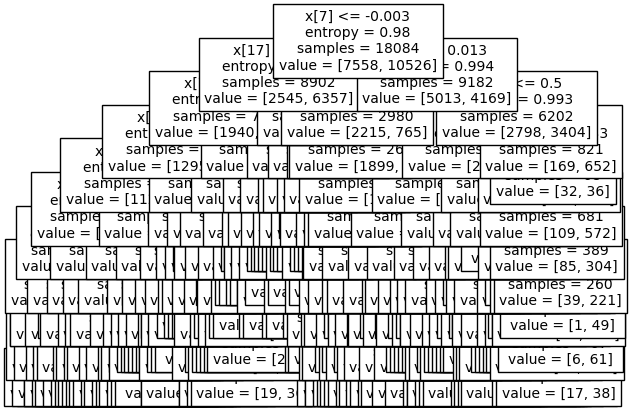

<Figure size 1000x600 with 0 Axes>

In [24]:
tree.plot_tree(tree_model["dt"],fontsize=10)
plt.figure(figsize=(10,6))
plt.show()

I would say that the features at the top of the decision tree are the most infulencial features in the decision tree model, such as X[7] Supervision_Risk_Score_First and X[17] Percent_Days_Employed. Higher a feature appears in a decision tree, more important it is, since decision tree selects the feature which provided the best split at each level.

If the method above was not satisfactory, you can try visualizing all the rules of the decision tree as text. Is this any better?

In [25]:
from sklearn.tree import export_text
tree_rules = export_text(tree_model.named_steps['dt'], feature_names=list(tree_model.named_steps['ct'].get_feature_names_out()))
print(tree_rules)

|--- pipeline-1__Percent_Days_Employed <= -0.00
|   |--- pipeline-2__Age_at_Release_48 or older <= 0.50
|   |   |--- pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0 <= 0.50
|   |   |   |--- pipeline-2__Gang_Affiliated_True <= 0.50
|   |   |   |   |--- pipeline-2__Prior_Arrest_Episodes_Misd_6 or more <= 0.50
|   |   |   |   |   |--- pipeline-1__Supervision_Risk_Score_First <= 0.20
|   |   |   |   |   |   |--- pipeline-1__Percent_Days_Employed <= -1.15
|   |   |   |   |   |   |   |--- pipeline-2__Gender_M <= 0.50
|   |   |   |   |   |   |   |   |--- pipeline-2__Residence_Changes_0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |   |--- pipeline-2__Residence_Changes_0 >  0.50
|   |   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |--- pipeline-2__Gender_M >  0.50
|   |   |   |   |   |   |   |   |--- pipeline-2__Prior_Conviction_Episodes_Prop_0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- pipeline-2__Prior_Arre

The method above was not satisfactory. In this case, visualizing all the rules of the decision tree as text is better. Because the tree structure is too complex and the tree size is relatively large in this case, image representation of the decision tree will not be ideal. Like the image above, it is difficult to see each node clearly from the image. Visualizing the decision tree rules as text provides a clearer picture of how the model makes decisions. The text representation lists the conditions for each node, making it easier to see the features and thresholds associated with each node.

When it is not possible to interpret a decision tree because of its complex structure, we can still extract other information from it that will help us understand the features' importance in the decision. The code in the cell below extracts the feature importances from the model (line 3), then uses this information to create a bar plot of features sorted by importance. The feature importance extracted this way is based on [Gini Importance](https://www.codecademy.com/article/fe-feature-importance-final) (as it is done in the original paper), which reflects how the features were picked when building the decision tree.

<Axes: >

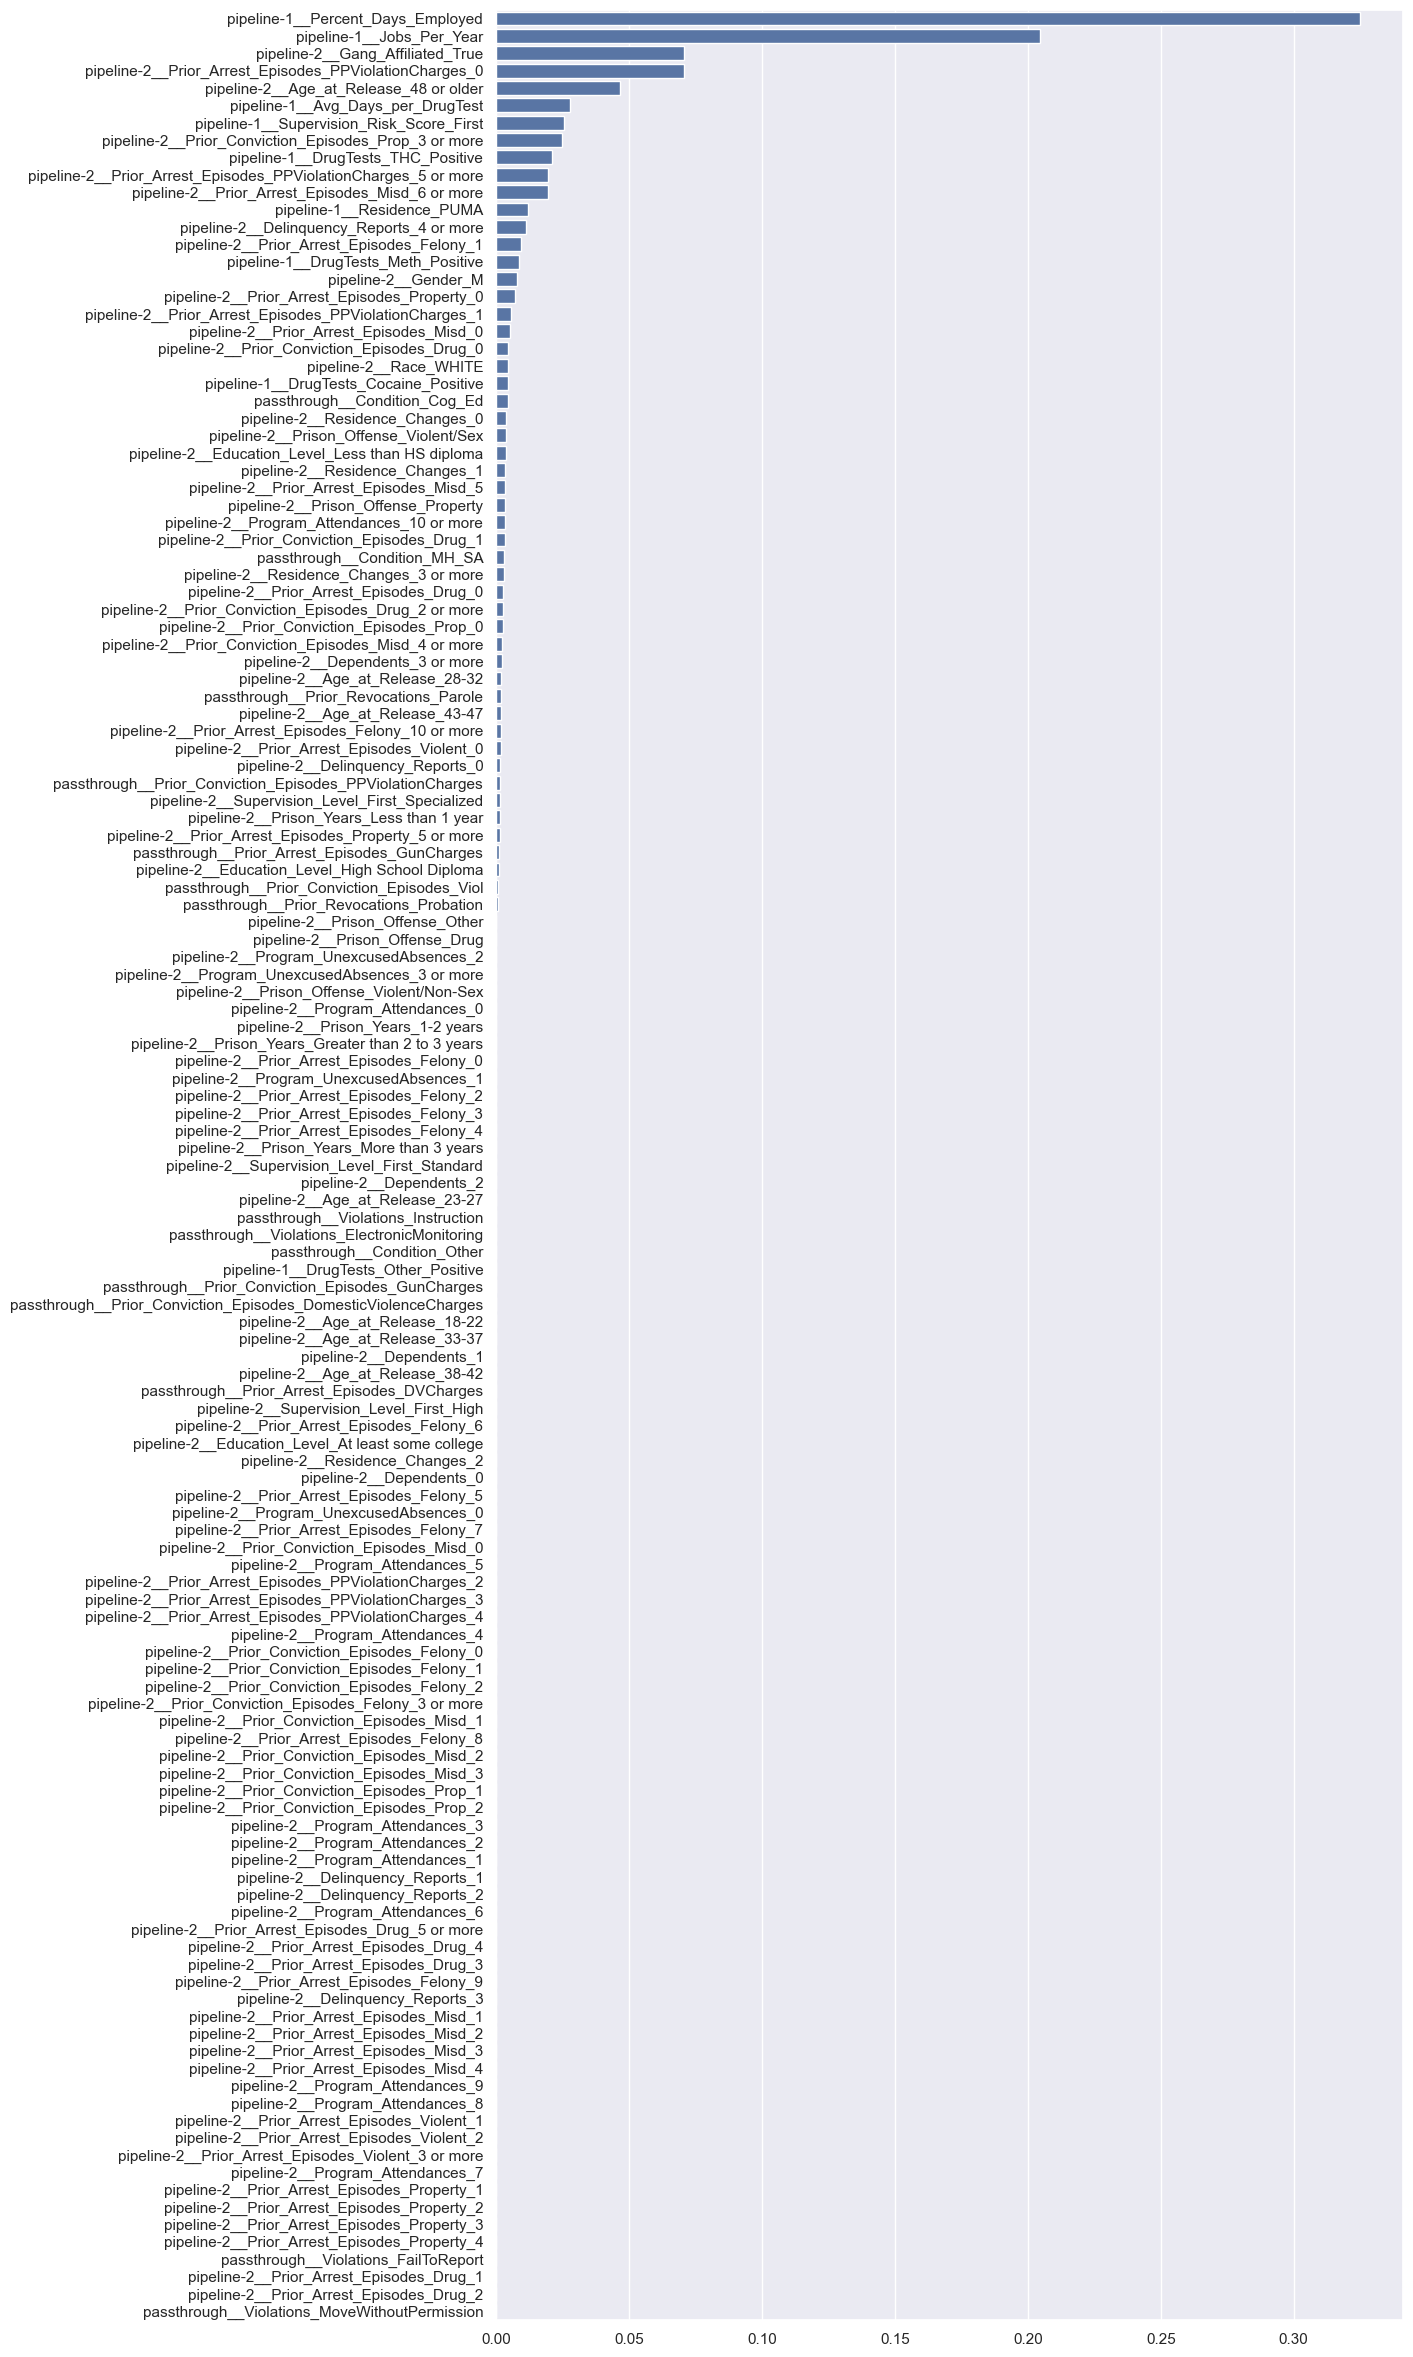

In [26]:
import seaborn as sns

feature_importances = tree_model.named_steps["dt"].feature_importances_

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = tree_model.named_steps['ct'].get_feature_names_out()[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# # Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(11.7,30)})
sns.barplot(x=sorted_importances, y=sorted_feature_names)

Comment on the features importance of the tree model, compared to those seen in the logistic regression model, as well as the original paper results. Also, **what is a big limitation of using feature importance, compared to observing the coefficient of the logistic regression model?**

As mentioned above, the feature importance of the decision tree reflects how much it helps reduce uncertainty. Consistent with the findings of the original paper, decision trees excel in terms of accuracy, but are not inherently interpretable. For example, Percent_Days_Employed is one of the most important features in the tree model, but the decision tree is unable to explain in which direction the increase or decrease of these features is pushing the prediction. In logistic regression, by contrast, the positivity or negativity of the coefficients indicates the direction of the impact prediction, making it easier to interpret. A key limitation of tree-based feature significance is that there is no way to explain how each feature affects the prediction, whereas the coefficients of logistic regression provide more transparency and are easier to interpret.

### Question 10

As before, we are interested in evaluating how the model classifies a particular sample. Let's start looking at the classification for our `hard_sample`. Is it correct?

In [27]:
# Your answer here 
tree_model.predict(hard_sample)

array([ True])

For this hard sample, the prediction made by the decision tree isn't match the actual value. It is incorrect.

We would like to be able to tell what sequence of rules has led to this final decision, but, for a tree this large, this can be difficult, unless we want to manually sift through the list of rules or write some elaborate custom code. In the next sections, we will see an alternative method (SHAP) to achieve this result.

### Question 11: Evaluation of Non-inherently Interpretable Models Using a Surrogate Model

Models that are not inherently interpretable ("black box" models) can still be examined to understand how they used the available features to make their predictions. In fact, there are many strategies to do this. The first one we are going to see is through use of a **surrogate model.** In this case, we train another model - an inherently interpretable one, such as a logistic regressor - on the *predictions* of the black box model, and then we try to interpret *its parameters*. Let's complete the code below to do that on the two non-inherently interpretable models included in this exercise: the Random Forest and XGBoost.

#### Surrogate for Random Forest Model

In [28]:
# Step 1: create logistic regressor object.
# For simplicity, we will use the already existing "NIJ_logreg.joblib" and re-train it, instead of creating
# a new one. The reason for this decision is that NIJ_logreg.joblib already knows how to handle the features
# of this dataset, while a new one will need to be designed to do so.

surrogate_model_rf = joblib.load("models_for_A3/NIJ_logreg.joblib")

# Step 2: train model on random forest predictions on the training set

rf_predictions = rf_model.predict(X_train)
surrogate_model_rf.fit(X_train, rf_predictions)

# Step 3: visualize weights of surrogate model, as we did for the original logistic regression model

coefficients_rf = surrogate_model_rf.named_steps["logisticregression"].coef_.flatten()
feature_names = np.array(surrogate_model_rf.named_steps['columntransformer'].get_feature_names_out())

coeff_df_rf = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients_rf})

coeff_df_rf_sorted = coeff_df_rf.sort_values(by='Coefficient', ascending=False)

print("Top 10 positive coefficients:")
print(coeff_df_rf_sorted.head(10))

print("\nTop 10 negative coefficients:")
print(coeff_df_rf_sorted.tail(10))


Top 10 positive coefficients:
                                          Feature  Coefficient
11               pipeline-2__Age_at_Release_18-22     0.796636
18               pipeline-2__Gang_Affiliated_True     0.790565
95              pipeline-2__Delinquency_Reports_1     0.650981
38     pipeline-2__Prior_Arrest_Episodes_Felony_0     0.489534
12               pipeline-2__Age_at_Release_23-27     0.488824
9                            pipeline-2__Gender_M     0.446960
124         passthrough__Prior_Revocations_Parole     0.370422
126                  passthrough__Condition_MH_SA     0.357176
8                       pipeline-1__Jobs_Per_Year     0.319845
129  passthrough__Violations_ElectronicMonitoring     0.319349

Top 10 negative coefficients:
                                               Feature  Coefficient
97                   pipeline-2__Delinquency_Reports_3    -0.204958
72   pipeline-2__Prior_Arrest_Episodes_PPViolationC...    -0.230000
15                    pipeline-2__Age_at_R

Now that we have the weights of the surrogate model, what can we say about how the Random Forest model makes its predictions? What features seem more important? Are they similar to what we have seen for the other models so far?

Based on the surrogate model's weights, features with larger magnitudes seem more important in the Random Forest model's predictions. We can see that the Random Forest model has similar significant features to other models. Key features such as age at release, gang affiliation, and delinquency reports appear to play major roles in influencing the predictions. Features with positive coefficients, like younger age and gang affiliation, push the model’s predictions towards recidivism. On the other hand, features with negative coefficients, such as older age and a higher number of delinquency reports, push predictions towards non-recidivism. Even the Random Forest modelis more complex, it still relies on similar important features to make predictions. 


**Note:** using a surrogate model is not always a very good strategy, because the simpler "white box" model is often unable to replicate the behavior of the most complex "black box" model. We can get a sense of how close the surrogate is approximating the original model by looking at the R<sup>2</sup> score. In the paper, they do so when trying to create a surrogate for XGBoost, and they explain: 

*The R<sup>2</sup> value between the XGBoost predictions and the surrogate model predictions on the test set is 0.38. The surrogate model only explains 38% of the variance in the XGBoost model’s predictions*

Test this for the random forest surrogate model. How much variance is it able to capture?

**Hints:**
- Think carefully about what constitues the array of predictions and the array of ground truths in this case
- You may remember that R<sup>2</sup> is, in fact, a metric for regression, not for classification! How can we use R<sup>2</sup> in this case? There are various ways to approximate R<sup>2</sup> for classification, as explained [here](https://datascience.oneoffcoder.com/psuedo-r-squared-logistic-regression.html). We will use the simplest one and use **count R<sup>2</sup>**, which is simply the accuracy of the surrogate classifier

In [29]:
# Your answer here
rf_predictions_train = rf_model.predict(X_train)
surrogate_predictions_rf_train = surrogate_model_rf.predict(X_train)

print("R^2 for random forest surrogate:", accuracy_score(rf_predictions_train, surrogate_predictions_rf_train))

R^2 for random forest surrogate: 0.7180380446803805


The R^2 score is approximately 0.718 for the surrogate model, which means that the surrogate model successfully captures about 71.8% of the variance in the Random Forest model's predictions. Overall, this R^2 is close to 1, which shows that the Random Forest’s behavior is not too complex to approximate and can be interpreted to a significant degree through the surrogate model.

Now, repeat the analysis through surrogate model for XGBoost. Comment on the results, including considerations on the following:
- What seem to be the most important features?
- How do the sets of most important features compare across models (do not forget logistic regression and decision tree in this comparison)?
- How good are the surrogate models, in terms of capturing the variance of the original model? Are they reliable?
- ...more thoughts of your choice...

#### Surrogate for XGBoost Model

In [53]:
# Your answer here
surrogate_model_xgb = joblib.load("models_for_A3/NIJ_logreg.joblib")

xgb_predictions = xgboost_model.predict(X_train)
surrogate_model_xgb.fit(X_train, xgb_predictions)

coefficients_xgb = surrogate_model_xgb.named_steps["logisticregression"].coef_.flatten()
feature_names = np.array(surrogate_model_rf.named_steps['columntransformer'].get_feature_names_out())

coeff_df_xgb = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients_xgb})

coeff_df_xgb_sorted = coeff_df_xgb.sort_values(by='Coefficient', ascending=False)

print("Top 10 positive coefficients:")
print(coeff_df_xgb_sorted.head(10))

print("\nTop 10 negative coefficients:")
print(coeff_df_xgb_sorted.tail(10))

xgb_predictions_train = xgboost_model.predict(X_train)
surrogate_predictions_xgb_train = surrogate_model_xgb.predict(X_train)

print("R^2 for XGBoost surrogate:", accuracy_score(xgb_predictions_train, surrogate_predictions_xgb_train))


Top 10 positive coefficients:
                                               Feature  Coefficient
11                    pipeline-2__Age_at_Release_18-22     1.344978
18                    pipeline-2__Gang_Affiliated_True     1.322722
9                                 pipeline-2__Gender_M     0.939579
95                   pipeline-2__Delinquency_Reports_1     0.853040
12                    pipeline-2__Age_at_Release_23-27     0.767391
38          pipeline-2__Prior_Arrest_Episodes_Felony_0     0.668436
126                       passthrough__Condition_MH_SA     0.643236
40   pipeline-2__Prior_Arrest_Episodes_Felony_10 or...     0.606695
36           pipeline-2__Prison_Years_Less than 1 year     0.591937
129       passthrough__Violations_ElectronicMonitoring     0.589146

Top 10 negative coefficients:
                                               Feature  Coefficient
35   pipeline-2__Prison_Years_Greater than 2 to 3 y...    -0.373178
41          pipeline-2__Prior_Arrest_Episodes_Felony_2 

In [54]:
coeffs = logreg_model.named_steps["logisticregression"].coef_.flatten()
coeff_df = pd.DataFrame(coeffs, index=feature_names, columns=["Coefficient"])
coeff_df_sorted = coeff_df.sort_values(by="Coefficient", ascending=False)
coeff_df_sorted

,Coefficient
pipeline-2__Gang_Affiliated_True,0.777359
pipeline-2__Age_at_Release_18-22,0.769493
pipeline-2__Delinquency_Reports_1,0.635820
pipeline-2__Age_at_Release_23-27,0.488786
pipeline-2__Prior_Arrest_Episodes_Felony_0,0.473336
...,...
pipeline-2__Program_Attendances_10 or more,-0.385807
pipeline-2__Prior_Arrest_Episodes_Felony_1,-0.501980
pipeline-2__Delinquency_Reports_4 or more,-0.507621
pipeline-1__Percent_Days_Employed,-0.663675


From the surrogate model results, the top positive coefficients indicate the features that contribute the most towards predicting a positive class, include “Age_at_Release_18-22”, “Gang_Affiliated_True”, and “Gender_M”. The top negative coefficients represent features that reduce the probability of a positive prediction. “Percent_Days_Employed” and “Age_at_Release_48 or older” are the most important negative features.

When we compare feature importance between XGBoost, logistic regression, and decision tree models, we can find some similar important features, such as "Gang_Affiliated" and "Age_at_Release" are important in all models. In particular, there is a lot of overlap between the important features of XGBoost and logistic regression, but the strength of the impact on the predictions is somewhat different. The decision tree will have some different important features present.

The R^2 score is approximately 0.815 for the surrogate model, which means that the surrogate model successfully captures about 81.5% of the variance in the XGBoost model.

Surrogate models are helpful to let the complex models more interpretable. In this case, the surrogate gives us a good idea of which features are most important. However, surrogate models simplify the original complex model, so it might missing and ignore some information, especially more complex relationships other than linear relationships between feature and feature.


### Question 12: Evaluation of Non-inherently Interpretable Models Using Permutation Feature Importance

Another method used to interpret black box models is using feature permutation, which means changing the value of a feature and observing changes in the model's prediction error. More important features, when changed, will result in more frequent mistakes.

Luckily for us, Permutation Feature Importance already exists as a function in Scikit-Learn! All you have to do it is looking at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) to learn how it works, and apply it to the 3 non-inherently interpretable models of this exercise. Let's start with Random Forest.

#### Random Forest Model:

In [32]:
# Use permutation_importance on the random forest model, and save the result in a variable called "out"
out = permutation_importance(rf_model, X_test, y_test)

After you are done, you can run the cell below to visualize the top 5 most important features in a bar chart. If you like, you can change the number of features shown or try other visualization methods.

<Axes: xlabel='Importance', ylabel='Name'>

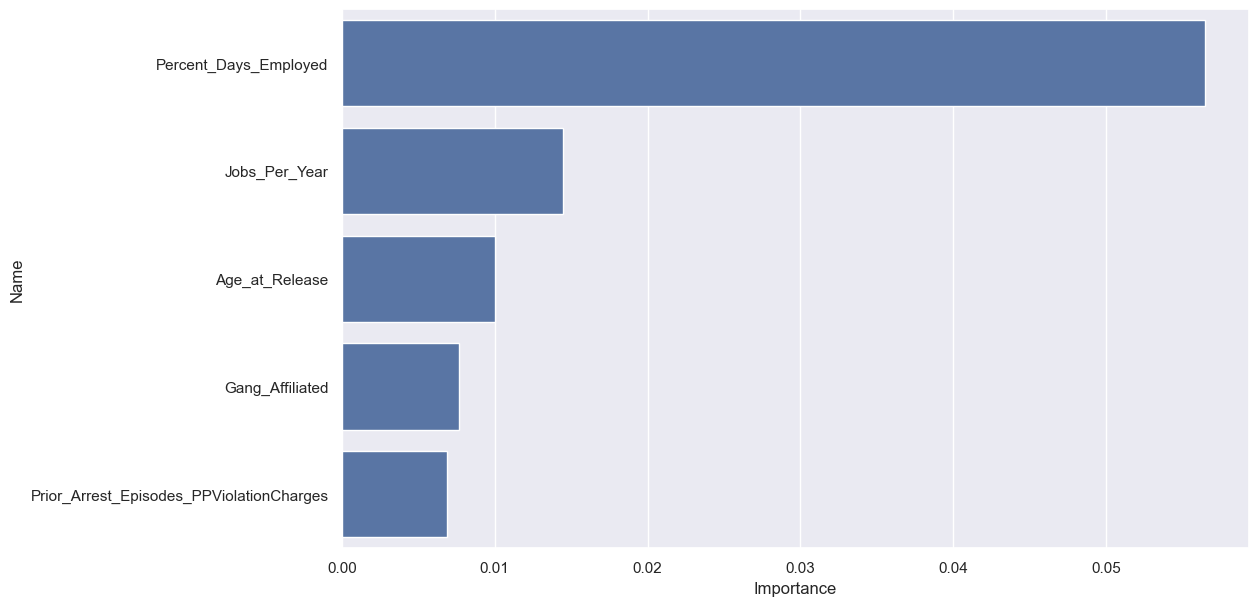

In [33]:
result = pd.DataFrame({"Name": X_test.columns, "Importance": out["importances_mean"], "STD": out["importances_std"]})
result = result.sort_values(by=['Importance'], ascending=False)

sns.set(rc={'figure.figsize':(11.7,7)})
sns.barplot(data=result[:5], y="Name", x="Importance")

Now, use Permutation Feature Importance on XGBoost.

**Hint:** this is a more complex model; if you find that this task is taking too long, you may consider reducing the number of permutations using the parameter `n_repeats`. Be aware that this produces more variable results.

#### XGBoost Model:

In [34]:
out2 = permutation_importance(xgboost_model, X_test, y_test)

<Axes: xlabel='Importance', ylabel='Name'>

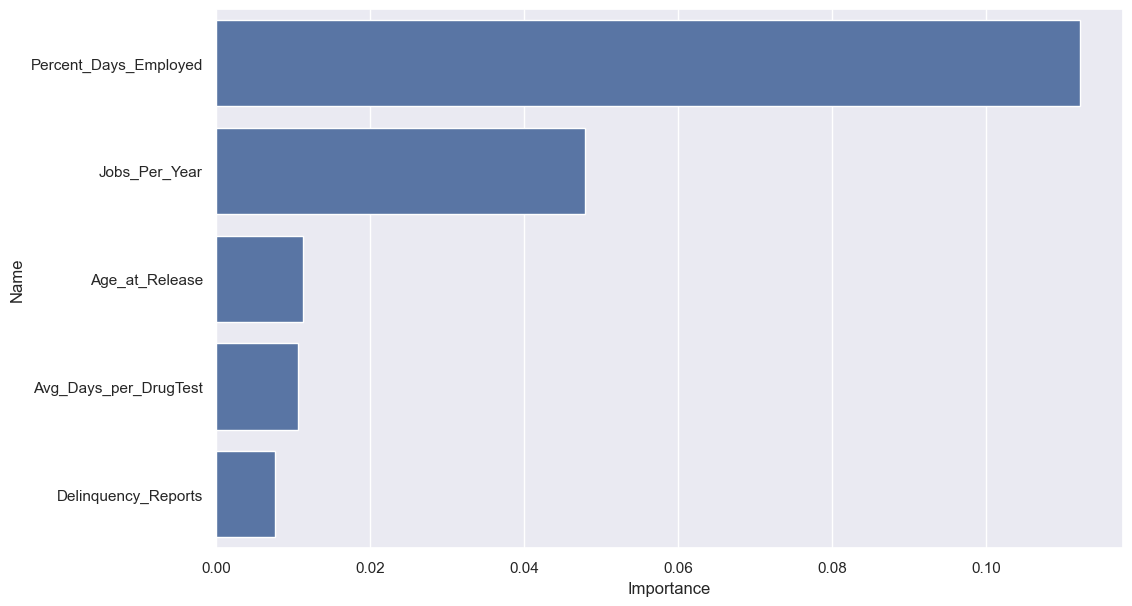

In [35]:
result2 = pd.DataFrame({"Name": X_test.columns, "Importance": out2["importances_mean"], "STD": out2["importances_std"]})
result2 = result2.sort_values(by=['Importance'], ascending=False)

sns.set_theme(rc={'figure.figsize':(11.7,7)})
sns.barplot(data=result2[:5], y="Name", x="Importance")

Now that you have completed your analysis of feature importance using permutation, comment on the results. How do the sets of most important features compare with each other? Are this results similar to what you observed using the surrogate model?

Some important features, such as "Supervision_Risk_Score_First" and "Percent_Days_Employed," were determined to be the most significant after the permutation feature importance analysis was completed. This indicates that these features are crucial to the model's predictions because the accuracy of the model decreased the greatest when they were shuffled. By observing how the model's performance varies when a feature is altered, permutation importance helps demonstrate how important each feature is.

Both the surrogate model and permutaion can identify important features, such as "Gang_Affiliated" and "Age_at_Release_18-22." The surrogate model is simpler and more interperatable, but might ignore the complex interactions between features. The permutation method, could catch direct effects and interactions.

### Question 13: Evaluation of Non-inherently Interpretable Models Using SHAP

The last method we are going to use to interpret the impact of each feature in our model is called SHAP, which stands for SHapley Additive exPlanations. How SHAP works is beyond the scope of this course, but if you are curious you can read the [original paper](https://arxiv.org/pdf/1705.07874.pdf) by Lundberg and Lee and check out [Lundberg's GitHub repo](https://github.com/shap/shap), which provides details on the implementation and examples.

You will need to install SHAP to be able to use it:
```
pip install shap
or
conda install -c conda-forge shap
```

Then, import it:

In [36]:
import shap # downgrade numpy to version = 1.23
shap.initjs()

SHAP needs the model (we will start with Random Forest) and samples to use to explain the predictions. For this, we will need to give it transformed samples (scaled and imputed, as required by the model) from  `X_train` or `X_test`.

In [37]:
X_train_enc = pd.DataFrame(
    data=rf_model.named_steps['ct'].transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

X_test_enc = pd.DataFrame(
    data=rf_model.named_steps['ct'].transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

ind = np.random.choice(len(X_test_enc) - 1, 1000)  
# This line just gives 1000 random indexes from the training set
# We do this because getting SHAP values for all samples would be a bit too long, but you 
# are free to try it out!

ind = np.append(ind, 106) # adding the hard sample - we'll need this later

The following lines are all that's needed to explain the model's predictions for a set of samples:

In [38]:
rf_explainer = shap.Explainer(rf_model[-1])  # creating SHAP Explainer based on the model

rf_shap_values = rf_explainer.shap_values(X_test_enc.iloc[ind])  # explaining predictions for 1000 random samples

This gives us the SHAP values for each sample and each feature (the index 1 indicates the positive class):

In [39]:
rf_shap_values[1]

array([[ 4.49563052e-03, -4.49563052e-03],
       [-4.17405790e-02,  4.17405790e-02],
       [ 5.34912540e-03, -5.34912540e-03],
       [-4.64995947e-02,  4.64995947e-02],
       [ 2.55268469e-03, -2.55268469e-03],
       [ 7.10197236e-03, -7.10197236e-03],
       [ 3.93555675e-03, -3.93555675e-03],
       [ 9.41014460e-02, -9.41014460e-02],
       [ 5.94953910e-02, -5.94953910e-02],
       [-2.76392666e-03,  2.76392666e-03],
       [ 2.65000150e-03, -2.65000150e-03],
       [ 2.79310520e-03, -2.79310520e-03],
       [ 6.44508266e-03, -6.44508266e-03],
       [-1.37122389e-02,  1.37122389e-02],
       [-2.00559018e-03,  2.00559018e-03],
       [-3.33935153e-04,  3.33935153e-04],
       [-1.29773820e-03,  1.29773820e-03],
       [-5.41176947e-03,  5.41176947e-03],
       [ 1.51724320e-02, -1.51724320e-02],
       [ 2.16823946e-03, -2.16823946e-03],
       [-2.56072394e-03,  2.56072394e-03],
       [-8.70889965e-03,  8.70889965e-03],
       [-3.73377466e-03,  3.73377466e-03],
       [-6.

This is hardly interpretable, though. It is better to get the average values for each feature, which returns something similar to feature importance:

In [40]:
values = np.abs(rf_shap_values[:,:,1]).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False)[:10]

,SHAP
pipeline-1__Percent_Days_Employed,0.072999
pipeline-2__Gang_Affiliated_True,0.027638
pipeline-1__Supervision_Risk_Score_First,0.025441
pipeline-1__DrugTests_THC_Positive,0.023567
pipeline-1__Jobs_Per_Year,0.021538
pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0,0.020443
pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_5 or more,0.016987
pipeline-2__Age_at_Release_48 or older,0.014727
pipeline-2__Prior_Conviction_Episodes_Misd_0,0.013314
pipeline-1__DrugTests_Meth_Positive,0.012513


The SHAP library also has a lot of ways to visualize and interpret the SHAP values - try it out!

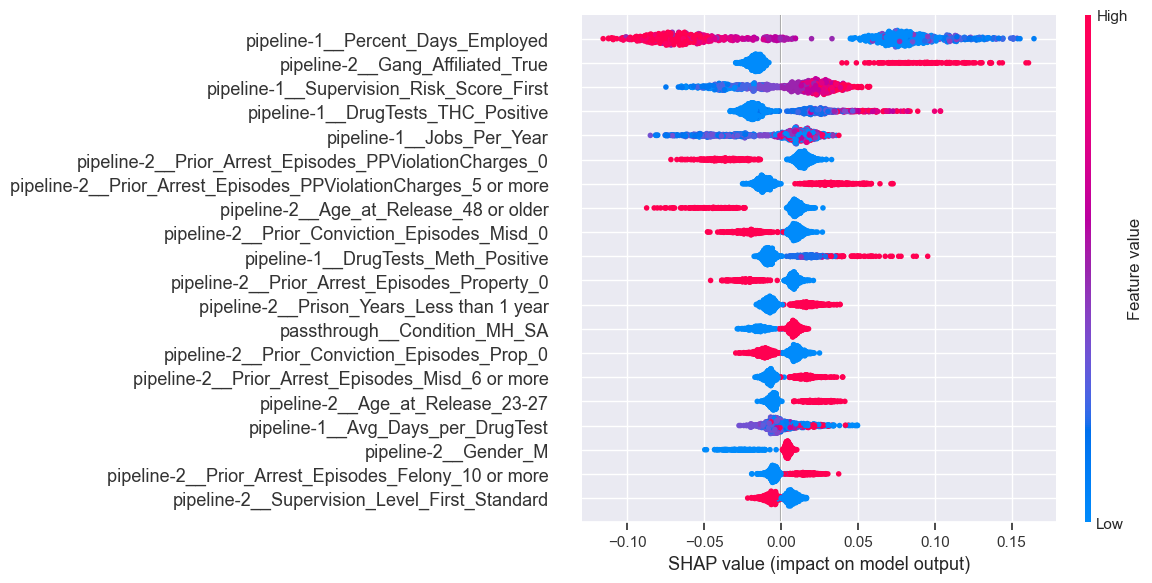

In [41]:

shap_figure = shap.summary_plot(rf_shap_values[:, :, 1], X_test_enc.iloc[ind], plot_size=[12,6]) 

Given the new information obtained using the SHAP library on the Random Forest model, explain the results (you will need to refer to the SHAP documentation - or ask us for help interpreting the plots) and comment on the difference between these results and those obtained using the other methods.


**Percent_Days_Employed** has the largest impact on the model output compared to other features. Specifically, when the percent of days employed is lower, it pushes the prediction toward the positive class, indicating higher risk, and vice versa.

A high value of **Gang_Affiliated_True8** strongly pushes the prediction upward, implying that gang affiliation significantly increases the likelihood of the positive class.

**Supervision_Risk_Score_First, DrugTests_THC_Positive, and Jobs_Per_Year** also have a considerable impact. Higher scores for these features positively affect the model output, increasing the risk prediction. However, while DrugTests_THC_Positive has a larger positive impact, the other two features tend to have more negative impacts.

**Age_at_Release_48 or older** shows a negative impact on the model, with older individuals being less likely to be labeled as at risk.

According to the plot, Percent_Days_Employed, Gang_Affiliated_True, Age_at_Release_48 or older, and Jobs_Per_Year are important features. This aligns closely with the feature importance from other methods. However, Delinquency_Reports_1 and Delinquency_Reports_4 or more are not considered important here.


Next, **repeat this analysis for XGBoost.**

In [42]:
# Your answer here

xgboost_explainer = shap.Explainer(xgboost_model[-1])  # creating SHAP Explainer based on the model

xgboost_shap_values = xgboost_explainer.shap_values(X_test_enc.iloc[ind])  # explaining predictions for 1000 random samples

In [43]:
values_xgboost = np.abs(xgboost_shap_values[1]).mean(0)
pd.DataFrame(data=values_xgboost, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]


,SHAP
pipeline-1__Residence_PUMA,0.042684
pipeline-2__Prior_Conviction_Episodes_Misd_2,0.042684
pipeline-2__Delinquency_Reports_4 or more,0.042684
pipeline-2__Delinquency_Reports_3,0.042684
pipeline-2__Delinquency_Reports_2,0.042684
pipeline-2__Delinquency_Reports_1,0.042684
pipeline-2__Delinquency_Reports_0,0.042684
pipeline-2__Prior_Conviction_Episodes_Drug_2 or more,0.042684
pipeline-2__Prior_Conviction_Episodes_Drug_1,0.042684
pipeline-2__Prior_Conviction_Episodes_Drug_0,0.042684


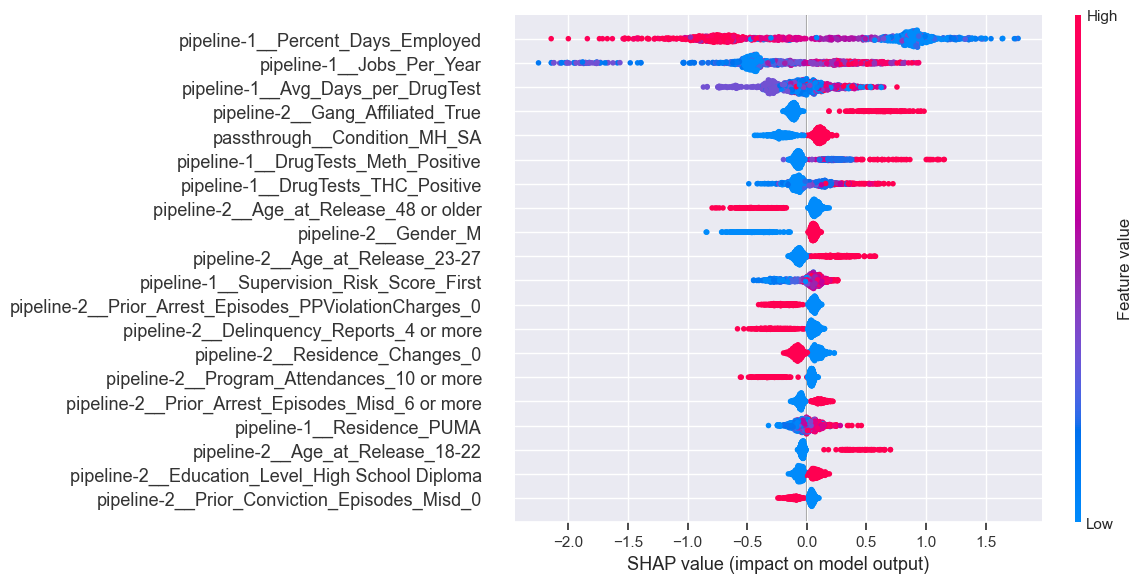

In [44]:

xgboost_figure = shap.summary_plot(xgboost_shap_values, X_test_enc.iloc[ind], plot_size=[12,6])


Percent_Days_Employed has the strongest negative impact, with higher employment pushing the prediction downward toward the negative class. If Percent_Days_Employed is high, the individual is more likely to be predicted as belonging to the negative class. In contrast, Jobs_Per_Year and Gang_Affiliated_True both have a large positive impact on the model's output when their values are high.

According to the plot, Percent_Days_Employed, Gang_Affiliated_True, Age_at_Release_48 or older, drugtest_meth_positive and Jobs_Per_Year are important features. This aligns closely with the feature importance from other methods. However, Delinquency_Reports_1 and Delinquency_Reports_4 or more are not considered important here.

### Question 14: Explaining individual predictions using SHAP

Another powerful feature of SHAP is that it allows us to explain the impact of each feature on individual predictions. For example, we will be able to explain how the prediction for our hard sample was generated. Let's start by looking at the prediction for this sample given by the random forest model. **Is it correct?**

Yes, correct.

In [45]:
shap_values = rf_explainer.shap_values(X_test_enc.iloc[ind[-1]])

pd.DataFrame(
    shap_values[:,1],
    index=feature_names,
    columns=["SHAP values"]).sort_values(
    by="SHAP values", ascending=False)



,SHAP values
pipeline-1__Jobs_Per_Year,0.029339
pipeline-1__DrugTests_THC_Positive,0.028623
pipeline-2__Prior_Conviction_Episodes_Prop_3 or more,0.026641
pipeline-2__Prior_Arrest_Episodes_Property_5 or more,0.017039
pipeline-2__Prior_Conviction_Episodes_Prop_0,0.016405
...,...
pipeline-2__Prison_Years_Less than 1 year,-0.008464
pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_5 or more,-0.010623
pipeline-2__Gang_Affiliated_True,-0.016029
pipeline-2__Gender_M,-0.026349


Let's look at the **force plot** for this particular prediction, by running the cell below:

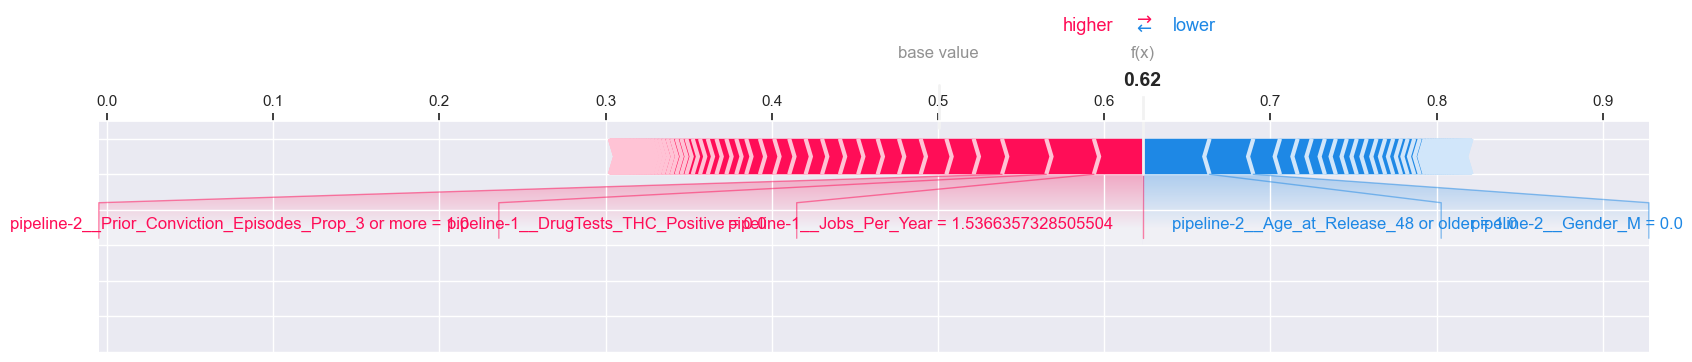

In [46]:
shap.force_plot(
    rf_explainer.expected_value[1],
    shap_values[:,1],
    X_test_enc.iloc[ind[-1]],
    matplotlib=True,
)

**Interpret the plot results,**, including the following:
- What contributed the most to the prediction?
- What countered the prediction the most?
- Can we tell, by looking at the plot, that this was a difficult prediction?

1. Jobs_Per_Year contributed the most. The larger the SHAP value of a feature, the greater the positive impact on the model’s output. This feature has the largest positive SHAP value (around 0.0293), significantly pushing the model's prediction toward the positive class. For this specific individual, he or she did 1.5 jobs per year, making them more likely to be labeled as at risk.

2. Age_at_Release_48 or older countered the most to the prediction. It has the largest negative SHAP value (around -0.040), indicating that it had the greatest negative effect on the model’s output, pulling the prediction toward a lower value. This individual was released at 48 years or older, which makes him or her less likely to be labeled as at risk.

3. Yes, this was a difficult prediction. The relatively balanced contributions of positive and negative features made it challenging. The expected value of the prediction is around 0.63, which is only slightly higher than the base value (0.5), indicating that the model was not strongly confident in its decision.

Finally, **repeat the analysis and comment on the results of the individual predictions made on the hard sample by XGBoost and Decision Tree** (since we were not able to do the latter earlier).

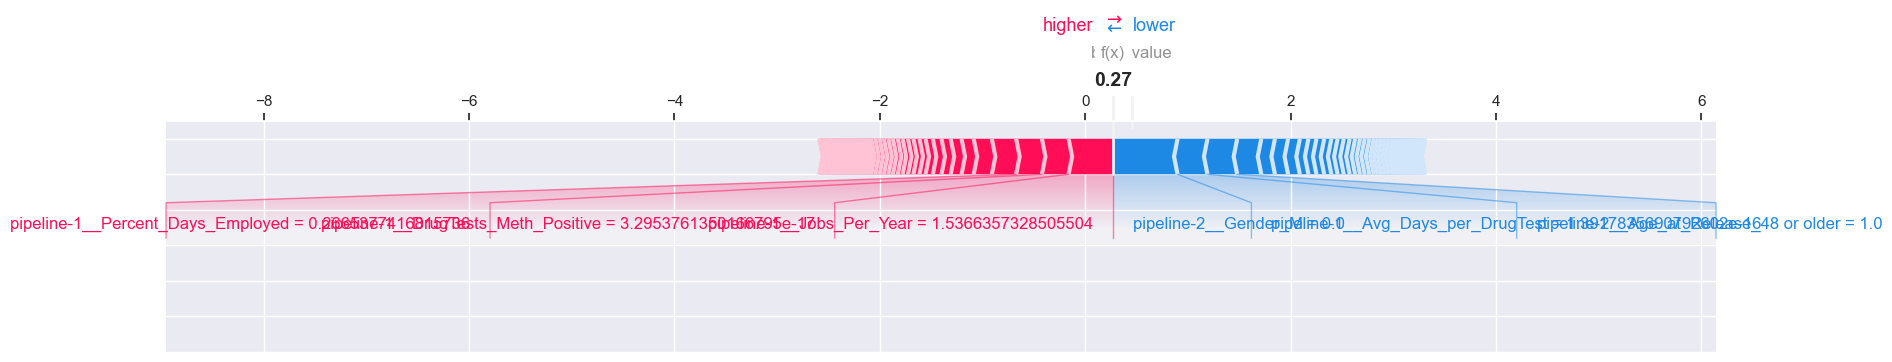

In [47]:
# Your answer here

shap.force_plot(
    xgboost_explainer.expected_value,
    xgboost_shap_values[-1], 
    X_test_enc.iloc[ind[-1]],
    matplotlib=True,
)

Jobs_Per_Year contributed the most. This feature has the largest positive SHAP value (around 0.4309), significantly pushing the model's prediction toward the positive class. For this individual, having 1.54 jobs per year makes them more likely to be labeled as at risk.

Gender_M countered the prediction the most. It has the largest negative SHAP value (around -0.6299), indicating that it had the greatest negative impact, pulling the prediction toward a lower value. Since this individual is male, the model was less likely to predict them as at risk.

No, this was not a challenging prediction. The predicted value is 0.27, which is slightly far from the baseline (0.5). Therefore, we can reasonably predict that this individual has a low risk.

In [48]:

tree_explainer = shap.Explainer(tree_model[-1])  # creating SHAP Explainer based on the model

tree_shap_values = tree_explainer.shap_values(X_test_enc.iloc[ind])

In [49]:

pd.DataFrame(
    tree_shap_values[-1,:,-1],
    index=feature_names,
    columns=["SHAP values"]).sort_values(
    by="SHAP values", ascending=False)

,SHAP values
pipeline-1__Percent_Days_Employed,0.168616
pipeline-1__DrugTests_Cocaine_Positive,0.053310
pipeline-1__Jobs_Per_Year,0.032276
pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_0,0.030374
pipeline-2__Prior_Conviction_Episodes_Drug_0,0.030371
...,...
pipeline-2__Prior_Arrest_Episodes_Misd_6 or more,-0.008180
pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_1,-0.009242
pipeline-2__Gang_Affiliated_True,-0.015517
pipeline-2__Prior_Arrest_Episodes_PPViolationCharges_5 or more,-0.018721


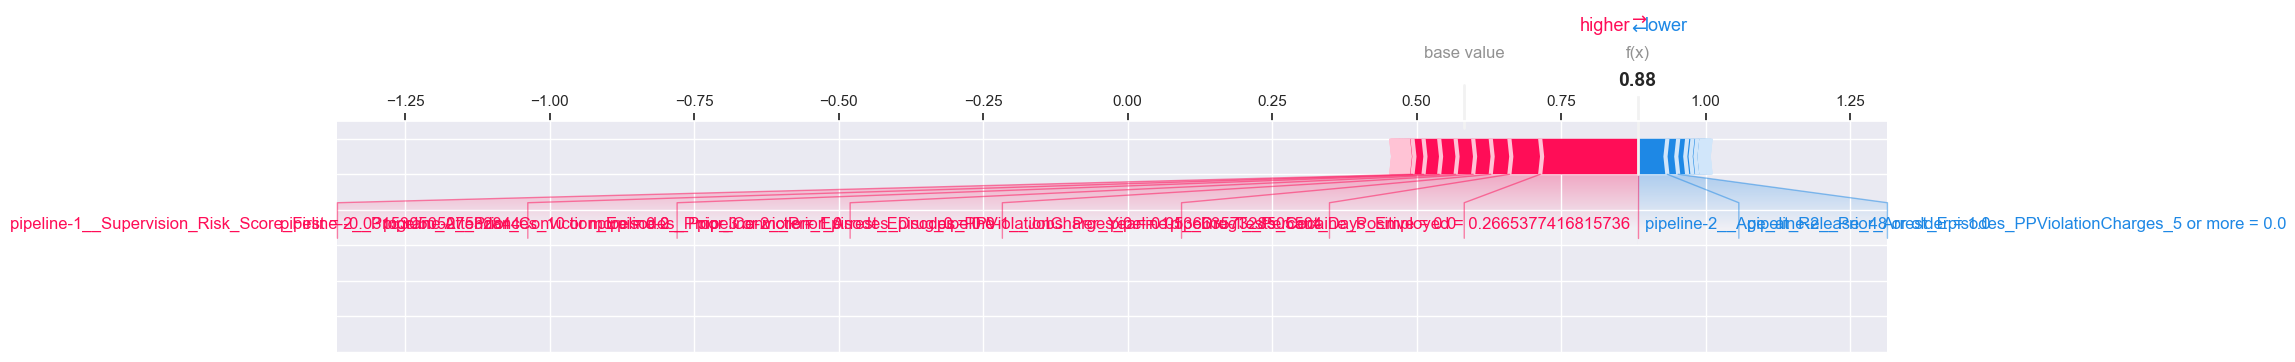

In [50]:

shap.force_plot(
    tree_explainer.expected_value[1],
    tree_shap_values[-1,:,-1],
    X_test_enc.iloc[ind[-1]],
    matplotlib=True,
)

Supervision_Risk_Score_First contributed the most. It has the largest positive SHAP value (around 1.25), strongly pushing the prediction toward the positive class. This suggests that a high supervision risk score indicates a greater likelihood of being labeled as at risk.

Percent_Days_Employed countered the prediction the most. It has the largest negative SHAP value (around -0.88), indicating that higher employment pushes the prediction downward toward the negative class. This suggests that the more days employed, the less likely the individual is to be considered at risk.

No, this was not a difficult prediction. The final predicted value is 0.88, which is far from the baseline value (0.5). We can confidently predict that this individual belongs to the positive class.

# Part 5: Final Evaluation:

### Question 15

Using **all the results collected so far** on accuracy, fairness and transparency of the 5 models, write your recommendation about what model, in your opinion, should be employed for this application (300 words max).

I would pick the XGBoost model for this application. It demonstrates the most balanced performance across key fairness metrics and has the lowest Average Distance from Reference, this ensures that both White and Black groups receive equitable treatment in the predictions, promoting fairness and consistency. However, this model is hard to interpret, which is a black box model. So surrogate model can also be a choice.

# Final thoughts

1) If you have completed this assignment in a group, please write a detailed description of how you divided the work and how you helped each other completing it:

We discussed our thoughts on the questions and shared our ideas with each other. And we divide the work so that each person could focus on specific parts of the assignment. We used GitHub to share our progress and make sure everything stayed organized. Once we completed all the questions, we came together to review the answers as a group, making sure that everything was clear and correct.

2) Have you used ChatGPT or a similar Large Language Model (LLM) to complete this homework? Please describe how you used the tool. We will never deduct points for using LLMs for completing homework assignments, but this helps us understand how you are using the tool and advise you in case we believe you are using it incorrectly.

We used ChatGPT to help us analyze and troubleshoot errors in our code when we couldn't resolve them on our own. ChatGPT provided suggestions on where the issues might be and how to fix them. Additionally, for this assignment, which involved a lot of written explanations, we used ChatGPT to help correct grammar mistakes in some parts of our written responses.

3) Have you struggled with some parts (or all) of this homework? Do you have pending questions you would like to ask? Write them down here!

 We’re unsure if we fully grasped how to explain the similarities and differences between the surrogate model and permutaion. 